<a href="https://colab.research.google.com/github/Toneejake/studybuddy-prototype/blob/main/kulab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install All Required Packages
print("Installing dependencies for SafeScape v2.0-Lite...")

# Core ML libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Standard ML tools
!pip install datasets Pillow matplotlib scikit-learn -q

# Gymnasium (compatible with SB3)
!pip install gymnasium==0.29.1 -q

# Stable Baselines3 + Contrib (for MaskablePPO)
!pip install stable-baselines3==2.2.1 -q
!pip install sb3-contrib==2.2.1 -q

# Utilities
!pip install opencv-python-headless tqdm -q

print("✅ All dependencies installed successfully!")
print("GPU Status:")
!nvidia-smi --query-gpu=name,memory.total --format=csv

Installing dependencies for SafeScape v2.0-Lite...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.0 MB/s eta 0:00:00
✅ All dependencies installed successfully!
GPU Status:
name, memory.total [MiB]
Tesla T4, 15360 MiB


In [2]:
# Cell 2: Import Libraries and Set Configuration

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output, display
import numpy as np
import heapq
import cv2
from tqdm import tqdm
import os
import random

# Gymnasium and RL libraries
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.utils import get_action_masks

# ============================================
# CONFIGURATION DICTIONARY
# ============================================
config = {
    # Perception AI
    "dataset_name": "zimhe/pseudo-floor-plan-12k",
    "image_size": 256,

    # Training
    "batch_size": 8,
    "learning_rate": 3e-4,

    # v2.0-Lite Specific
    "max_agents": 10,          # Fixed observation space
    "max_exits": 248,          # Perimeter of 256x256 grid minus corners
    "num_training_layouts": 20, # Number of diverse floor plans for Lite
    "training_timesteps": 100000, # Total training steps for Lite

    # Simulation
    "fire_spread_prob": 0.25,
    "firewall_spread_factor": 0.1,
    "max_steps_per_episode": 500,

    # Model paths
    "unet_model_path": "unet_floorplan_model.pth",
    "ppo_model_path": "ppo_commander_v2.0_lite.zip",
    "checkpoint_dir": "./checkpoints_v2_lite/",
}

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
print(f"📋 Config loaded: Training on {config['num_training_layouts']} layouts for {config['training_timesteps']} timesteps")

🖥️  Device: cuda
📋 Config loaded: Training on 20 layouts for 100000 timesteps


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# Cell 3: U-Net Architecture for Floor Plan Perception

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

def create_grid_from_image(model, image_path, image_size, device):
    """Convert floor plan image to binary grid using U-Net."""
    model.to(device)
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    try:
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

    with torch.no_grad():
        output = model(input_tensor)

    output_probs = torch.sigmoid(output)
    binary_mask = (output_probs > 0.5).float()
    grid_numpy = binary_mask.squeeze().cpu().numpy()

    return grid_numpy

print("✅ U-Net architecture defined")

✅ U-Net architecture defined


In [4]:
# Cell 4: Load Pre-trained U-Net Model

# Check if model exists
if not os.path.exists(config['unet_model_path']):
    print("⚠️  U-Net model not found!")
    print(f"Please upload '{config['unet_model_path']}' to this Colab session.")
    print("\nOptions:")
    print("1. Upload manually using the file browser (left sidebar)")
    print("2. Mount Google Drive and copy from there")
    print("3. Run this command if you have it in Drive:")
    print("   !cp /content/drive/MyDrive/path/to/unet_floorplan_model.pth .")
else:
    perception_model = UNet()
    perception_model.load_state_dict(torch.load(config['unet_model_path'], map_location=device))
    perception_model.to(device)
    perception_model.eval()
    print("✅ U-Net model loaded successfully!")
    print(f"   Model parameters: {sum(p.numel() for p in perception_model.parameters()):,}")

✅ U-Net model loaded successfully!
   Model parameters: 7,782,913


🏗️  Generating procedural floor plans for training...


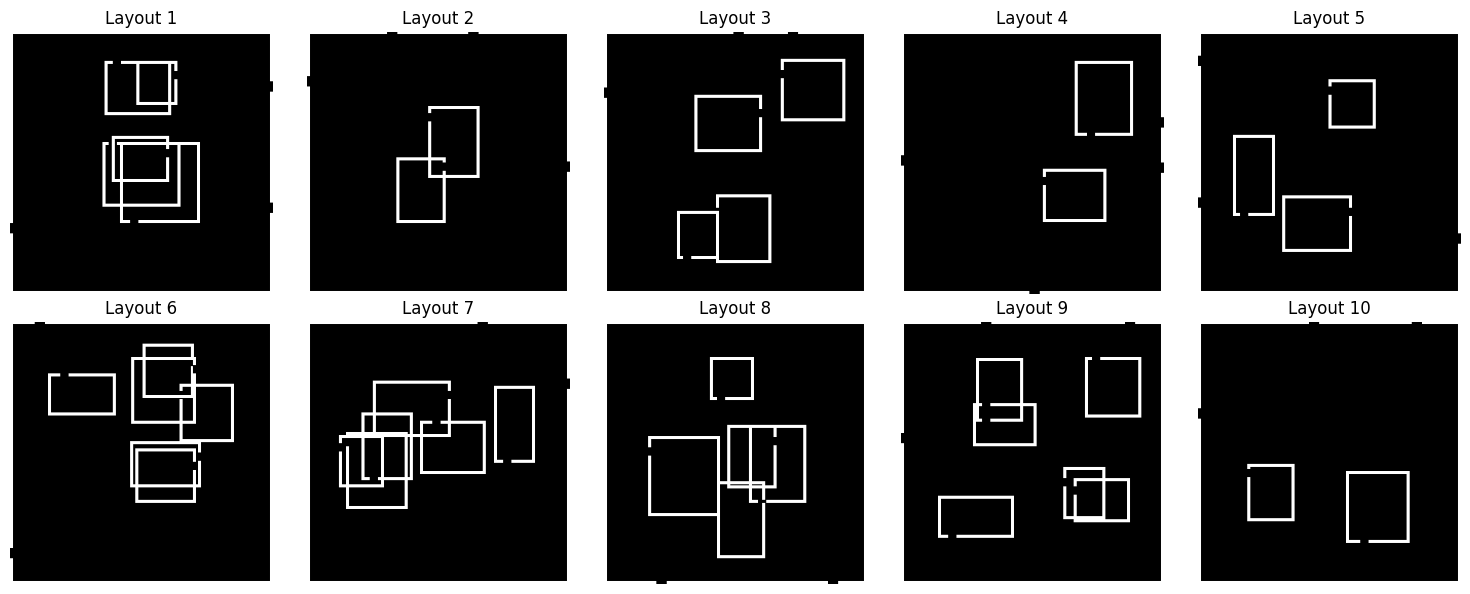

✅ Generated 20 diverse floor plans for training


In [5]:
# Cell 5: Procedural Floor Plan Generator for Training Diversity

class ProceduralFloorPlanGenerator:
    """Generates diverse synthetic floor plans for training."""

    def __init__(self, size=256):
        self.size = size

    def generate_simple_building(self, num_rooms=4, seed=None):
        """Generate a random floor plan with rooms and corridors."""
        if seed is not None:
            np.random.seed(seed)

        grid = np.zeros((self.size, self.size), dtype=np.float32)

        # Add outer walls
        grid[0:3, :] = 1
        grid[-3:, :] = 1
        grid[:, 0:3] = 1
        grid[:, -3:] = 1

        # Divide into random rooms
        for _ in range(num_rooms):
            # Random room position and size
            room_w = np.random.randint(40, 80)
            room_h = np.random.randint(40, 80)
            x = np.random.randint(20, self.size - room_w - 20)
            y = np.random.randint(20, self.size - room_h - 20)

            # Draw room walls
            grid[y:y+3, x:x+room_w] = 1
            grid[y+room_h-3:y+room_h, x:x+room_w] = 1
            grid[y:y+room_h, x:x+3] = 1
            grid[y:y+room_h, x+room_w-3:x+room_w] = 1

            # Add random door
            door_side = np.random.randint(0, 4)
            door_pos = np.random.randint(5, 15)
            if door_side == 0:  # Top
                grid[y:y+3, x+door_pos:x+door_pos+8] = 0
            elif door_side == 1:  # Bottom
                grid[y+room_h-3:y+room_h, x+door_pos:x+door_pos+8] = 0
            elif door_side == 2:  # Left
                grid[y+door_pos:y+door_pos+8, x:x+3] = 0
            else:  # Right
                grid[y+door_pos:y+door_pos+8, x+room_w-3:x+room_w] = 0

        # Create exits by removing sections of outer wall
        num_exits = np.random.randint(2, 5)
        for _ in range(num_exits):
            side = np.random.randint(0, 4)
            pos = np.random.randint(20, self.size - 30)
            if side == 0:  # Top
                grid[0:3, pos:pos+10] = 0
            elif side == 1:  # Bottom
                grid[-3:, pos:pos+10] = 0
            elif side == 2:  # Left
                grid[pos:pos+10, 0:3] = 0
            else:  # Right
                grid[pos:pos+10, -3:] = 0

        return grid

    def generate_dataset(self, num_layouts=20):
        """Generate a set of diverse floor plans."""
        layouts = []
        for i in range(num_layouts):
            num_rooms = np.random.randint(2, 7)
            layout = self.generate_simple_building(num_rooms=num_rooms, seed=i*100)
            layouts.append(layout)
        return layouts

# Generate training layouts
print("🏗️  Generating procedural floor plans for training...")
generator = ProceduralFloorPlanGenerator(size=config['image_size'])
training_layouts = generator.generate_dataset(num_layouts=config['num_training_layouts'])

# Visualize a sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(training_layouts):
        ax.imshow(training_layouts[i], cmap='gray')
        ax.set_title(f"Layout {i+1}")
        ax.axis('off')
plt.tight_layout()
plt.show()

print(f"✅ Generated {len(training_layouts)} diverse floor plans for training")

In [6]:
# Cell 6: Fire Simulator, A*, and Person Agent

# ============================================
# A* PATHFINDING
# ============================================
def a_star_search(grid, start, goal, fire_map=None):
    """A* pathfinding with fire avoidance."""
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        close_set.add(current)

        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[1] and 0 <= neighbor[1] < grid.shape[0]:
                if grid[neighbor[1]][neighbor[0]] == 1:
                    continue
                if fire_map is not None and fire_map[neighbor[1]][neighbor[0]] == 1:
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return []

# ============================================
# FIRE SIMULATOR
# ============================================
class FireSimulator:
    def __init__(self, grid, spread_probability=0.25, firewall_spread_factor=0.1):
        self.base_grid = grid
        self.spread_probability = spread_probability
        self.firewall_spread_factor = firewall_spread_factor
        self.fire_map = np.zeros_like(self.base_grid, dtype=float)
        self.directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def start_fire(self, ignition_points):
        for y, x in ignition_points:
            if 0 <= y < self.fire_map.shape[0] and 0 <= x < self.fire_map.shape[1]:
                self.fire_map[y, x] = 1

    def step(self):
        new_fire_map = self.fire_map.copy()
        rows, cols = self.fire_map.shape
        burning_cells = np.argwhere(self.fire_map == 1)

        for r, c in burning_cells:
            for dr, dc in self.directions:
                nr, nc = r + dr, c + dc

                if 0 <= nr < rows and 0 <= nc < cols:
                    if self.fire_map[nr, nc] == 0:
                        neighbor_type = self.base_grid[nr, nc]

                        current_spread_prob = self.spread_probability
                        if neighbor_type == 1:
                            current_spread_prob = 0
                        elif neighbor_type == 2:
                            current_spread_prob *= self.firewall_spread_factor

                        if np.random.rand() < current_spread_prob:
                            new_fire_map[nr, nc] = 1

        self.fire_map = new_fire_map

    def reset(self, ignition_points=None):
        self.fire_map = np.zeros_like(self.base_grid, dtype=float)
        if ignition_points:
            self.start_fire(ignition_points)

# ============================================
# PERSON AGENT (Agent-Based Model)
# ============================================
class Person:
    def __init__(self, position):
        self.initial_pos = tuple(position)
        self.pos = list(position)
        self.path = []
        self.status = 'evacuating'
        self.state = 'CALM'
        self.speed = 1.0
        self.trip_probability = 0.0
        self.tripped_timer = 0
        self.PANIC_DISTANCE = 25
        self.ALERT_DISTANCE = 50

    def update_state(self, fire_map):
        if self.tripped_timer > 0:
            return

        fire_locations = np.argwhere(fire_map == 1)
        if len(fire_locations) == 0:
            min_dist = float('inf')
        else:
            agent_pos_yx = np.array([self.pos[1], self.pos[0]])
            min_dist = np.min(np.linalg.norm(fire_locations - agent_pos_yx, axis=1))

        if min_dist < self.PANIC_DISTANCE:
            self.state = 'PANICKED'
            self.speed = 1.5
            self.trip_probability = 0.1
        elif min_dist < self.ALERT_DISTANCE:
            self.state = 'ALERT'
            self.speed = 1.2
            self.trip_probability = 0.0
        else:
            self.state = 'CALM'
            self.speed = 1.0
            self.trip_probability = 0.0

    def move(self):
        if self.tripped_timer > 0:
            self.tripped_timer -= 1
            return

        if self.state == 'PANICKED':
            if np.random.rand() < self.trip_probability:
                self.tripped_timer = 5
                return

        steps_to_move = int(round(self.speed))
        for _ in range(steps_to_move):
            if self.path:
                self.pos = list(self.path.pop(0))
            else:
                break

    def check_status(self, fire_map, exits):
        if self.status != 'evacuating':
            return

        pos_int = (int(self.pos[1]), int(self.pos[0]))
        if fire_map[pos_int[0], pos_int[1]] == 1:
            self.status = 'burned'
            return

        for ex in exits:
            if np.linalg.norm(np.array(self.pos) - np.array(ex)) < 5:
                self.status = 'escaped'
                return

    def compute_path(self, grid, goal, fire_map):
        start_pos = (int(self.pos[0]), int(self.pos[1]))
        goal_pos = (int(goal[0]), int(goal[1]))
        self.path = a_star_search(grid, start_pos, goal_pos, fire_map)

    def reset(self):
        self.pos = list(self.initial_pos)
        self.path = []
        self.status = 'evacuating'
        self.state = 'CALM'
        self.speed = 1.0
        self.trip_probability = 0.0
        self.tripped_timer = 0

print("✅ Core simulation classes defined (A*, FireSimulator, Person)")

✅ Core simulation classes defined (A*, FireSimulator, Person)


In [7]:
# Cell 7: UPGRADED Gymnasium Environment v2.0 with Fixed Spaces

class EvacuationEnvV2(gym.Env):
    """
    V2.0 Upgrade: Fixed observation/action spaces with masking for generalization.
    """

    def __init__(self, grid, num_agents=5, max_steps=500,
                 agent_start_positions=None, fire_start_position=None, exits=None):
        super(EvacuationEnvV2, self).__init__()

        self.base_grid = grid
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.initial_agent_positions = agent_start_positions
        self.initial_fire_position = fire_start_position
        self.initial_exits = exits

        # === V2.0 UPGRADE: Fixed Action Space ===
        self.MAX_EXITS = config['max_exits']
        self.action_space = spaces.Discrete(self.MAX_EXITS)

        # === V2.0 UPGRADE: Fixed Observation Space ===
        self.MAX_AGENTS = config['max_agents']
        fire_obs_shape = 64 * 64
        agent_pos_shape = self.MAX_AGENTS * 2
        agent_state_shape = self.MAX_AGENTS * 1
        obs_shape = fire_obs_shape + agent_pos_shape + agent_state_shape + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(obs_shape,), dtype=np.float32)

        # Define perimeter exit slots (248 positions around edge)
        self.all_possible_exit_slots = self._generate_exit_slots()

        # Find actual exits
        self.exits = self._find_exits() if self.initial_exits is None else self.initial_exits
        if not self.exits:
            raise ValueError("No exits found or provided.")

        # Map exits to slots
        self.valid_exit_indices = self._map_exits_to_slots()

        # Fire simulator
        self.fire_sim = FireSimulator(self.base_grid)
        self.agents = []

    def _generate_exit_slots(self):
        """Generate 248 possible exit positions around perimeter."""
        size = self.base_grid.shape[0]
        slots = []

        # Top edge
        for x in range(1, size-1):
            slots.append((x, 1))

        # Bottom edge
        for x in range(1, size-1):
            slots.append((x, size-2))

        # Left edge (excluding corners)
        for y in range(1, size-1):
            slots.append((1, y))

        # Right edge (excluding corners)
        for y in range(1, size-1):
            slots.append((size-2, y))

        return slots[:self.MAX_EXITS]  # Ensure exactly MAX_EXITS

    def _find_exits(self):
        """Find exits on perimeter automatically."""
        rows, cols = self.base_grid.shape
        exits = []

        for x in range(cols):
            if self.base_grid[1, x] == 0:
                exits.append((x, 1))
            if self.base_grid[rows-2, x] == 0:
                exits.append((x, rows-2))

        for y in range(rows):
            if self.base_grid[y, 1] == 0:
                exits.append((1, y))
            if self.base_grid[y, cols-2] == 0:
                exits.append((cols-2, y))

        if not exits:
            return []

        # Filter to avoid duplicates
        filtered_exits = [exits[0]]
        for ex in exits:
            if all(np.linalg.norm(np.array(ex) - np.array(f_ex)) > 20 for f_ex in filtered_exits):
                filtered_exits.append(ex)

        return filtered_exits

    def _map_exits_to_slots(self):
        """Map actual exits to nearest exit slots."""
        indices = []
        for exit_pos in self.exits:
            distances = [np.linalg.norm(np.array(exit_pos) - np.array(slot))
                        for slot in self.all_possible_exit_slots]
            nearest_idx = np.argmin(distances)
            indices.append(nearest_idx)
        return indices

    def action_masks(self):
        """V2.0: Return boolean mask for valid exits."""
        mask = np.zeros(self.MAX_EXITS, dtype=bool)
        mask[self.valid_exit_indices] = True
        return mask

    def _get_observation(self):
        """V2.0: Fixed-size observation with zero-padding."""
        # Fire map (64x64)
        fire_map_resized = cv2.resize(self.fire_sim.fire_map.astype(np.float32),
                                     (64, 64), interpolation=cv2.INTER_AREA)
        fire_obs = fire_map_resized.flatten()

        # Agent positions (zero-padded to MAX_AGENTS)
        agent_positions = np.zeros(self.MAX_AGENTS * 2, dtype=np.float32)
        for i, agent in enumerate(self.agents[:self.MAX_AGENTS]):
            agent_positions[i*2] = agent.pos[0] / self.base_grid.shape[1]
            agent_positions[i*2 + 1] = agent.pos[1] / self.base_grid.shape[0]

        # Agent states (zero-padded)
        state_map = {'CALM': 0.0, 'ALERT': 0.5, 'PANICKED': 1.0}
        agent_states = np.zeros(self.MAX_AGENTS, dtype=np.float32)
        for i, agent in enumerate(self.agents[:self.MAX_AGENTS]):
            agent_states[i] = state_map.get(agent.state, 0.0)

        # Time
        time_obs = np.array([self.current_step / self.max_steps])

        return np.concatenate([fire_obs, agent_positions, agent_states, time_obs]).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # Reset fire
        fire_start = self.initial_fire_position or (self.base_grid.shape[0] // 2, self.base_grid.shape[1] // 2)
        self.fire_sim.reset(ignition_points=[fire_start])

        # Reset agents
        self.agents = []
        if self.initial_agent_positions:
            for pos in self.initial_agent_positions[:self.num_agents]:
                self.agents.append(Person(position=pos))
        else:
            while len(self.agents) < self.num_agents:
                y, x = np.random.randint(10, self.base_grid.shape[0]-10), \
                       np.random.randint(10, self.base_grid.shape[1]-10)
                if self.base_grid[y, x] == 0 and self.fire_sim.fire_map[y, x] == 0:
                    self.agents.append(Person(position=(x, y)))

        for agent in self.agents:
            agent.reset()

        return self._get_observation(), {}

    def step(self, action):
        self.current_step += 1
        self.fire_sim.step()

        # V2.0: Map action to actual exit
        if action in self.valid_exit_indices:
            target_exit = self.exits[self.valid_exit_indices.index(action)]
        else:
            # Invalid action chosen (shouldn't happen with masking)
            target_exit = self.exits[0]

        reward = -0.01

        for agent in self.agents:
            if agent.status == 'evacuating':
                agent.update_state(self.fire_sim.fire_map)

                if agent.state != 'PANICKED' and (not agent.path or self.current_step % 10 == 0):
                    agent.compute_path(self.base_grid, target_exit, self.fire_sim.fire_map)

                agent.move()
                agent.check_status(self.fire_sim.fire_map, self.exits)

                if agent.status == 'escaped':
                    reward += 10
                elif agent.status == 'burned':
                    reward -= 10

        terminated = all(agent.status != 'evacuating' for agent in self.agents)
        truncated = self.current_step >= self.max_steps

        return self._get_observation(), reward, terminated, truncated, {}

print("✅ V2.0 Environment with action masking defined")

✅ V2.0 Environment with action masking defined


In [8]:
# Cell 8: Action Masking Wrapper for MaskablePPO

def make_env(layout_grid, rank=0):
    """Factory function to create wrapped environment."""
    def _init():
        num_agents = np.random.randint(3, config['max_agents'] + 1)
        env = EvacuationEnvV2(
            grid=layout_grid,
            num_agents=num_agents,
            max_steps=config['max_steps_per_episode']
        )
        # Wrap with ActionMasker
        env = ActionMasker(env, lambda env: env.action_masks())
        return env
    return _init

print("✅ Environment wrapper with action masking ready")

✅ Environment wrapper with action masking ready


In [9]:
# Cell 9: Custom Training Callback for Progress Tracking

class TrainingProgressCallback(BaseCallback):
    """Logs training metrics and displays progress."""

    def __init__(self, verbose=0):
        super(TrainingProgressCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self):
        # Log episodic data
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                self.episode_rewards.append(info['r'])
                self.episode_lengths.append(info['l'])
        return True

    def _on_training_end(self):
        """Plot final results."""
        if len(self.episode_rewards) > 0:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(self.episode_rewards)
            plt.title('Episode Rewards')
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')

            plt.subplot(1, 2, 2)
            plt.plot(self.episode_lengths)
            plt.title('Episode Lengths')
            plt.xlabel('Episode')
            plt.ylabel('Steps')

            plt.tight_layout()
            plt.savefig('training_progress_v2_lite.png', dpi=150)
            plt.show()

            print(f"\n📊 Training Statistics:")
            print(f"   Average Reward: {np.mean(self.episode_rewards[-100:]):.2f}")
            print(f"   Average Length: {np.mean(self.episode_lengths[-100:]):.2f}")

print("✅ Training callback defined")

✅ Training callback defined


In [10]:
# Cell 10: Train MaskablePPO on Multiple Layouts

os.makedirs(config['checkpoint_dir'], exist_ok=True)

print("="*60)
print("🚀 STARTING V2.0-LITE TRAINING")
print("="*60)
print(f"Training Configuration:")
print(f"  • Layouts: {len(training_layouts)}")
print(f"  • Total timesteps: {config['training_timesteps']}")
print(f"  • Max agents per episode: {config['max_agents']}")
print(f"  • Checkpoint frequency: every 10,000 steps")
print("="*60)

# Create vectorized environments with random layout selection
def make_random_layout_env(rank):
    """Randomly select a layout for each environment reset."""
    def _init():
        layout = random.choice(training_layouts)
        num_agents = np.random.randint(3, config['max_agents'] + 1)
        env = EvacuationEnvV2(
            grid=layout,
            num_agents=num_agents,
            max_steps=config['max_steps_per_episode']
        )
        env = ActionMasker(env, lambda e: e.action_masks())
        return env
    return _init

# Create 4 parallel environments
n_envs = 4
vec_env = SubprocVecEnv([make_random_layout_env(i) for i in range(n_envs)])
vec_env = VecMonitor(vec_env)

# MaskablePPO hyperparameters
model_kwargs = {
    "learning_rate": config['learning_rate'],
    "n_steps": 2048,
    "batch_size": 256,
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "policy_kwargs": dict(net_arch=dict(pi=[256, 256], vf=[256, 256])),
    "verbose": 1,
    "device": 'cuda',
    "tensorboard_log": "./tensorboard_v2_lite/"
}

# Check if continuing from checkpoint
if os.path.exists(config['ppo_model_path']):
    print(f"\n✅ Found existing model: {config['ppo_model_path']}")
    print("   Loading model to continue training...")
    model = MaskablePPO.load(config['ppo_model_path'], env=vec_env, device='cuda')
else:
    print("\n🆕 Creating new MaskablePPO model...")
    model = MaskablePPO("MlpPolicy", vec_env, **model_kwargs)

# Setup callbacks
checkpoint_callback = CheckpointCallback(
    save_freq=10000 // n_envs,
    save_path=config['checkpoint_dir'],
    name_prefix='ppo_v2_lite'
)
progress_callback = TrainingProgressCallback()

# TRAIN
print(f"\n🏋️  Training for {config['training_timesteps']} timesteps...")
print("   This will take approximately 2-3 hours on T4 GPU\n")

model.learn(
    total_timesteps=config['training_timesteps'],
    callback=[checkpoint_callback, progress_callback],
    progress_bar=True,
    reset_num_timesteps=False
)

# Save final model
model.save(config['ppo_model_path'])
vec_env.close()

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"Model saved to: {config['ppo_model_path']}")
print(f"Total timesteps trained: {model.num_timesteps:,}")
print(f"Checkpoints saved in: {config['checkpoint_dir']}")
print("="*60)

🚀 STARTING V2.0-LITE TRAINING
Training Configuration:
  • Layouts: 20
  • Total timesteps: 100000
  • Max agents per episode: 10
  • Checkpoint frequency: every 10,000 steps

🆕 Creating new MaskablePPO model...
Using cuda device

🏋️  Training for 100000 timesteps...
   This will take approximately 2-3 hours on T4 GPU

Logging to ./tensorboard_v2_lite/PPO_0


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

EOFError: 

In [ ]:
# Cell 11: Test V2.0-Lite Model on New Layout

print("🧪 Testing trained model on a new procedural layout...\n")

# Generate a completely new test layout (not in training set)
test_generator = ProceduralFloorPlanGenerator(size=256)
test_layout = test_generator.generate_simple_building(num_rooms=5, seed=999)

# Create test environment
test_env = EvacuationEnvV2(
    grid=test_layout,
    num_agents=7,
    max_steps=500
)
test_env = ActionMasker(test_env, lambda e: e.action_masks())

# Load trained model
trained_model = MaskablePPO.load(config['ppo_model_path'])

# Run simulation
obs, _ = test_env.reset()
terminated, truncated = False, False
history = []

while not terminated and not truncated:
    action_masks = get_action_masks(test_env)
    action, _ = trained_model.predict(obs, action_masks=action_masks, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    history.append({
        'fire_map': test_env.fire_sim.fire_map.copy(),
        'agents': [{'pos': agent.pos, 'status': agent.status,
                   'state': agent.state, 'tripped': agent.tripped_timer > 0}
                  for agent in test_env.agents],
        'step': test_env.current_step
    })

# Results
final_state = history[-1]
escaped = sum(1 for a in final_state['agents'] if a['status'] == 'escaped')
burned = sum(1 for a in final_state['agents'] if a['status'] == 'burned')
total = len(final_state['agents'])

print("="*50)
print("📊 TEST RESULTS")
print("="*50)
print(f"Total agents: {total}")
print(f"Escaped: {escaped} ({escaped/total*100:.1f}%)")
print(f"Burned: {burned} ({burned/total*100:.1f}%)")
print(f"Simulation steps: {final_state['step']}")
print("="*50)

# Visualize test layout
plt.figure(figsize=(8, 8))
plt.imshow(test_layout, cmap='gray')
plt.title("Test Floor Plan (Unseen During Training)")
plt.axis('off')
plt.show()

print("\n✅ Model generalization test complete!")

In [ ]:
# Cell 12: Animated Visualization of Test Simulation

print("🎬 Generating animation...\n")

fig, ax = plt.subplots(figsize=(10, 10))

def animate(frame_index):
    ax.clear()
    frame = history[frame_index]

    # Background grid
    ax.imshow(test_layout, cmap='gray')

    # Fire overlay
    ax.imshow(frame['fire_map'], cmap='Reds', alpha=0.6)

    # Draw agents
    for agent_data in frame['agents']:
        pos = agent_data['pos']
        status = agent_data['status']
        state = agent_data['state']
        tripped = agent_data['tripped']

        # Color coding
        if status == 'escaped':
            color = 'lime'
        elif status == 'burned':
            color = 'black'
        elif state == 'PANICKED':
            color = 'orange'
        elif state == 'ALERT':
            color = 'yellow'
        else:
            color = 'blue'

        # Shape
        if tripped:
            shape = patches.Ellipse((pos[0], pos[1]), width=6, height=3,
                                   color=color, alpha=0.9, zorder=10)
        else:
            shape = patches.Circle((pos[0], pos[1]), radius=3,
                                  color=color, alpha=0.9, zorder=10)
        ax.add_patch(shape)

    ax.set_title(f"AI Commander V2.0-Lite | Step: {frame['step']}", fontsize=16)
    ax.axis('off')

anim = FuncAnimation(fig, animate, frames=len(history), interval=100)
plt.close()

print("✅ Animation ready!")
display(HTML(anim.to_jshtml()))

In [ ]:
# Cell 13: Training Summary and Upgrade Path

print("\n" + "="*70)
print("🎉 SAFESCAPE V2.0-LITE TRAINING COMPLETE")
print("="*70)

print("\n📦 FILES CREATED:")
print(f"  ✅ {config['ppo_model_path']} - Trained model")
print(f"  ✅ {config['checkpoint_dir']} - Training checkpoints")
print(f"  ✅ training_progress_v2_lite.png - Performance graphs")
print(f"  ✅ ./tensorboard_v2_lite/ - TensorBoard logs")

print("\n🔬 MODEL CAPABILITIES:")
print("  ✅ Works on variable floor plan layouts")
print("  ✅ Handles 1-10 agents dynamically")
print("  ✅ Supports user-defined exits")
print("  ✅ Action masking for safe decisions")
print("  ✅ Trained on 20 diverse layouts")

print("\n🚀 UPGRADE PATH TO V2.0-FULL:")
print("  To train on 1000+ layouts next week:")
print("  1. Download full dataset:")
print("     dataset = load_dataset('zimhe/pseudo-floor-plan-12k')")
print("  2. Process 1000 layouts with U-Net")
print("  3. Load this Lite model:")
print(f"     model = MaskablePPO.load('{config['ppo_model_path']}')")
print("  4. Continue training:")
print("     model.learn(total_timesteps=500000)")
print("  5. Save as 'ppo_commander_v2.0_full.zip'")

print("\n💡 USER WORKFLOW CONFIRMED:")
print("  ✅ User uploads floor plan → U-Net detects walls")
print("  ✅ User marks exits → Environment validates")
print("  ✅ User places agents + fire → Simulation runs")
print("  ✅ AI selects optimal exit → Agents evacuate")
print("  ✅ Results displayed → Risk assessment shown")

print("\n🔧 FIREWALL FEATURE:")
print("  ⚠️  Code exists but NOT trained yet")
print("  To enable:")
print("  1. User marks firewall locations on UI")
print("  2. Set grid values: 0=free, 1=wall, 2=firewall")
print("  3. FireSimulator already handles spread (10% through firewalls)")
print("  4. Include firewall layouts in training data")

print("\n" + "="*70)
print("Next step: Copy this notebook to continue training for v2.0-Full")
print("="*70)